In [1]:
#Import libs
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sklearn
from scipy.stats import zscore

import string
import nltk
from nltk.corpus import  stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score,recall_score,roc_curve,auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import joblib

In [2]:
df=pd.read_csv('review_rating.csv')
df

,Unnamed: 0,Review,Rating
0,0,"I’m really enjoying this laptop, though the di...",4.4 out of 5
1,1,First PC that I’ve ever owned that is faster t...,4.4 out of 5
2,2,Good PC for the money!,4.4 out of 5
3,3,"Aspire 5, Ryzen 3, Vega 3 Graphics, 16GB RAM D...",4.5 out of 5
4,4,Very happy with this laptop. Extremely light. ...,4.5 out of 5
...,...,...,...
30376,30376,Works like a charm. Thanks so much.,4.2 out of 5
30377,30377,It was very easy to setup. It gives great cove...,4.2 out of 5
30378,30378,quality equipment delivered 4 days early. Awesome,4.2 out of 5
30379,30379,So far it's an awesome product.,4.2 out of 5


In [3]:
df.shape

(30381, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30381 entries, 0 to 30380
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30381 non-null  int64 
 1   Review      30381 non-null  object
 2   Rating      30381 non-null  object
dtypes: int64(1), object(2)
memory usage: 712.2+ KB


In [5]:
df.isnull().sum()

Unnamed: 0    0
Review        0
Rating        0
dtype: int64

In [6]:
df=df.drop(columns=["Unnamed: 0"], axis=1)

In [7]:
df['Rating']=df['Rating'].str.replace('out of 5', '')
df["Rating"] = pd.to_numeric(df["Rating"])

In [8]:
print(df['Rating'].value_counts(),'\n') 

4.4    4354
4.5    4116
4.3    3603
4.6    3145
4.2    2804
4.7    2754
4.1    2164
4.0    1692
3.9    1186
4.8    1006
3.8    1006
3.7     543
3.6     497
5.0     338
3.5     193
4.9     181
3.3     166
3.4     163
3.2      83
3.1      80
3.0      68
2.9      58
2.6      44
2.7      41
0.0      28
2.5      18
2.8      16
2.2      10
2.0       9
1.5       5
1.0       5
1.7       2
2.3       2
1.8       1
Name: Rating, dtype: int64 



In [9]:
rating=[]
rating=df['Rating']

In [10]:
ratings=[]
for x in rating:
    y=x
    x=int(x)
    if x == 0:
        ratings.append(x+1)
    else:
        if ((y-x) >= 0.5):
            z=x+1
            ratings.append(z)
        else:
            ratings.append(x)

In [11]:
df['Rating']=ratings

In [12]:
print(df['Rating'].value_counts(),'\n') 

4    18042
5    11540
3      737
1       33
2       29
Name: Rating, dtype: int64 



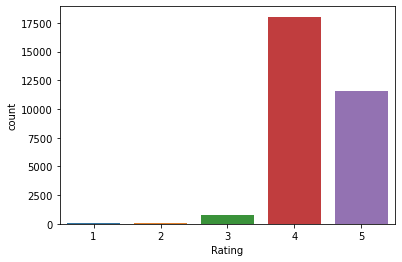

In [13]:
sns.countplot(df['Rating'])
plt.show()

In [14]:
df.describe()

,Rating
count,30381.000000
mean,4.350416
std,0.543059
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000


In [15]:
#New column for Length of message
df['length'] = df.Review.str.len()
df

,Review,Rating,length
0,"I’m really enjoying this laptop, though the di...",4,562
1,First PC that I’ve ever owned that is faster t...,4,114
2,Good PC for the money!,4,22
3,"Aspire 5, Ryzen 3, Vega 3 Graphics, 16GB RAM D...",5,1019
4,Very happy with this laptop. Extremely light. ...,5,210
...,...,...,...
30376,Works like a charm. Thanks so much.,4,35
30377,It was very easy to setup. It gives great cove...,4,154
30378,quality equipment delivered 4 days early. Awesome,4,49
30379,So far it's an awesome product.,4,31


In [16]:
df['Review'] = df['Review'].str.lower()

In [17]:
# Replace email addresses with 'email'
df['Review'] = df['Review'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
df['Review'] = df['Review'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['Review'] = df['Review'].str.replace(r'£|\$', 'dollers')

# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['Review'] = df['Review'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')   

# Replace numbers with 'numbr'
df['Review'] = df['Review'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [18]:
# Remove punctuation
df['Review'] = df['Review'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between teemlrms with a single space
df['Review'] = df['Review'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['Review'] = df['Review'].str.replace(r'^\s+|\s+?$', '')

In [19]:
df.head()

,Review,Rating,length
0,i m really enjoying this laptop though the dis...,4,562
1,first pc that i ve ever owned that is faster t...,4,114
2,good pc for the money,4,22
3,aspire numbr ryzen numbr vega numbr graphics n...,5,1019
4,very happy with this laptop extremely light ve...,5,210


In [20]:
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

#Tokenize and Lemmatize
def preprocess(text):
    result=[]
    for token in text:
            result.append(lemmatize_stemming(token))        
    return result

In [21]:
# Remove stopwords
import string
import nltk
from nltk.corpus import  stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['Review'] = df['Review'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

df['Review'] = preprocess(df['Review'])

In [22]:
# New column (clean_length) after puncuations,stopwords removal
df['clean_length'] = df.Review.str.len()
df.head()

,Review,Rating,length,clean_length
0,really enjoying laptop though display really f...,4,562,379
1,first pc ever owned faster macbook pro every t...,4,114,72
2,good pc money,4,22,13
3,aspire numbr ryzen numbr vega numbr graphics n...,5,1019,732
4,happy laptop extremely light fast boot convert...,5,210,145


In [23]:
# Total length removal
print ('Origian Length', df.length.sum())
print ('Clean Length', df.clean_length.sum())

Origian Length 26406033
Clean Length 16775269


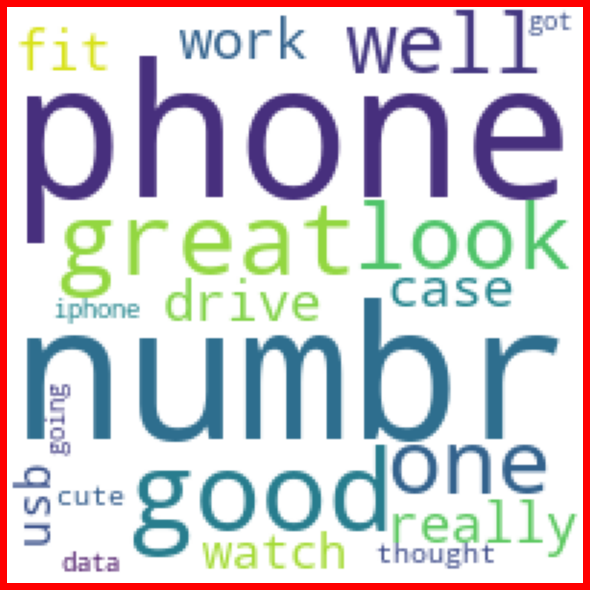

In [24]:
#Getting sense of loud words in spam 1
from wordcloud import WordCloud
bad = df['Review'][df['Rating'] == 1]
bad_cloud = WordCloud(width=200,height=200,background_color='white',max_words=20).generate(' '.join(bad))
plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(bad_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

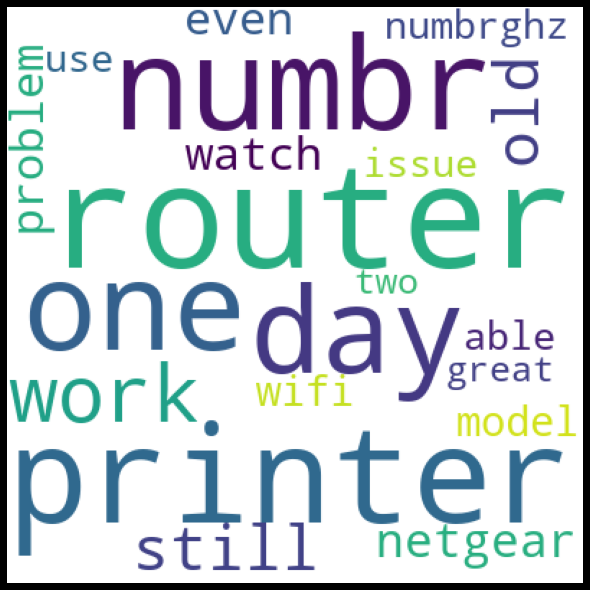

In [25]:
#Getting sense of loud words in ham 2
okay = df['Review'][df['Rating'] == 2]
okay_cloud = WordCloud (width=400, height=400, background_color='white', max_words=20).generate(' '.join(okay))
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(okay_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

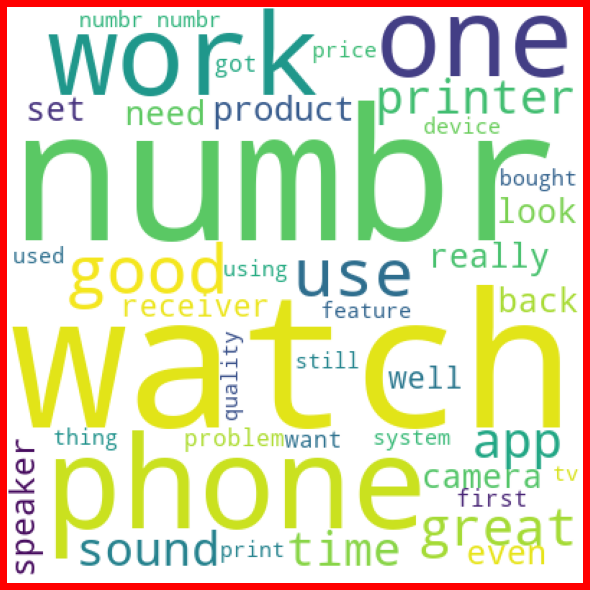

In [26]:
#Getting sense of loud words in spam 3
good = df['Review'][df['Rating'] == 3]
good_cloud = WordCloud(width=400,height=400,background_color='white',max_words=40).generate(' '.join(good))
plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(good_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

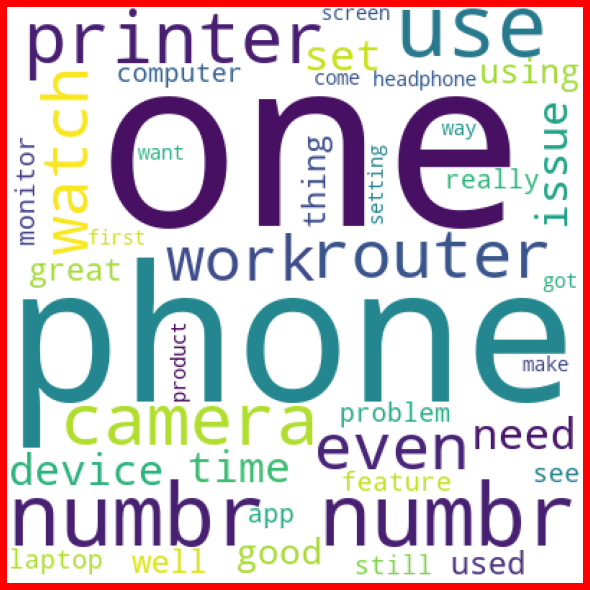

In [27]:
#Getting sense of loud words in spam 4
better = df['Review'][df['Rating'] == 4]
better_cloud = WordCloud(width=400,height=400,background_color='white',max_words=40).generate(' '.join(better))
plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(better_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

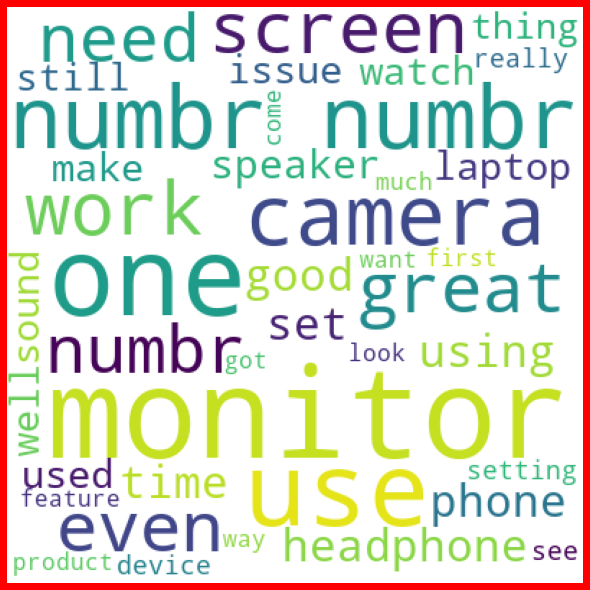

In [28]:
#Getting sense of loud words in spam 5
best = df['Review'][df['Rating'] == 5]
best_cloud = WordCloud(width=400,height=400,background_color='white',max_words=40).generate(' '.join(best))
plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(best_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [29]:
tf_vec = TfidfVectorizer()
features = tf_vec.fit_transform (df['Review'])

x = features
y = df['Rating']

In [30]:
import imblearn
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [31]:
print(y.value_counts(),'\n') 

5    18042
4    18042
3    18042
2    18042
1    18042
Name: Rating, dtype: int64 



In [32]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.33,random_state=42) 

In [33]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(60440, 39114) (29770, 39114)
(60440,) (29770,)


In [34]:
MNB=MultinomialNB()
GBC=GradientBoostingClassifier()
RFC=RandomForestClassifier()
KNN=KNeighborsClassifier()
SV=SVC()
LR=LogisticRegression()
DT=DecisionTreeClassifier()

In [35]:
models = []
models.append(('KNeighborsClassifier', KNN))
models.append(('SVC', SV))
models.append(('LogisticRegression', LR))
models.append(('DecisionTreeClassifier', DT))
models.append(('MultinomialNB', MNB))
models.append(('RandomForestClassifier', RFC))
models.append(('GradientBoostingClassifier', GBC))

In [36]:
classes_q = sorted(df.Rating.unique())
classes_q

[1, 2, 3, 4, 5]

*********************** KNeighborsClassifier ***********************


KNeighborsClassifier()


Accuracy_score =  0.8015787705744037


roc_auc_score =  0.8749121106954716


classification_report
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      6099
           2       1.00      1.00      1.00      5925
           3       0.97      1.00      0.98      5991
           4       0.65      0.01      0.02      5875
           5       0.51      0.99      0.67      5880

    accuracy                           0.80     29770
   macro avg       0.82      0.80      0.73     29770
weighted avg       0.83      0.80      0.74     29770



[[6099    0    0    0    0]
 [   0 5925    0    0    0]
 [   0   15 5972    3    1]
 [   6    4  129   61 5675]
 [   5    1   38   30 5806]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)


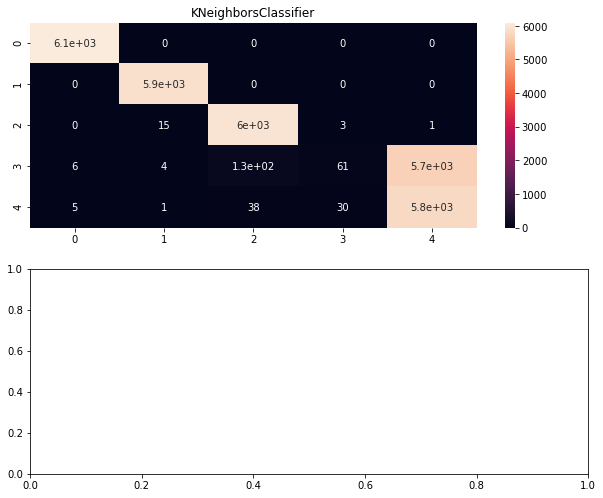

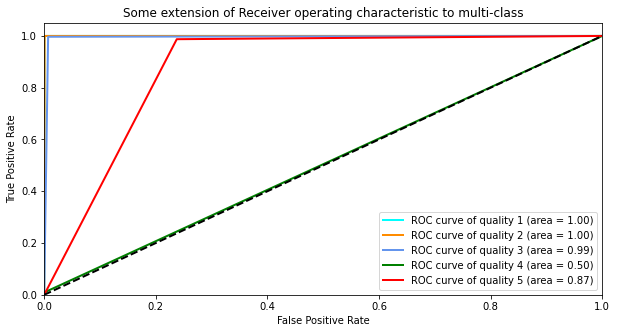




*********************** SVC ***********************


SVC()


Accuracy_score =  0.9148471615720524


roc_auc_score =  0.946360353972901


classification_report
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      6099
           2       0.99      1.00      1.00      5925
           3       1.00      0.99      0.99      5991
           4       0.74      0.89      0.81      5875
           5       0.87      0.69      0.77      5880

    accuracy                           0.91     29770
   macro avg       0.92      0.91      0.91     29770
weighted avg       0.92      0.91      0.91     29770



[[6099    0    0    0    0]
 [   0 5925    0    0    0]
 [   0   34 5920   37    0]
 [   2    7    9 5239  618]
 [   3    0   11 1814 4052]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)


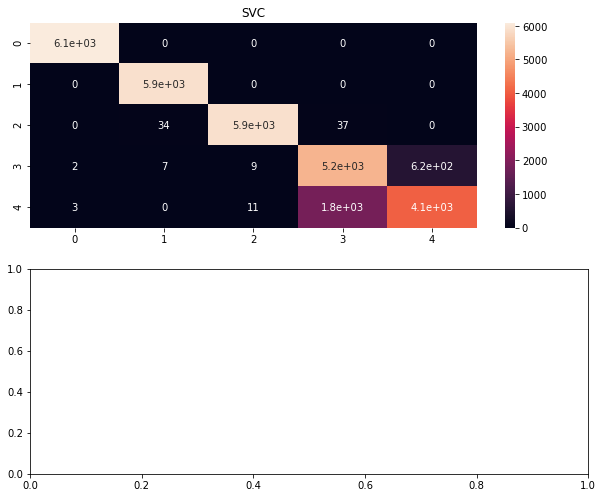

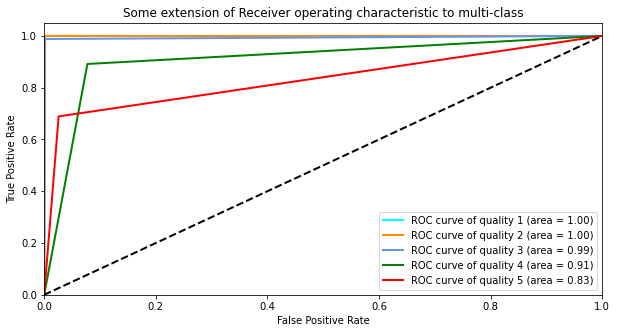




*********************** LogisticRegression ***********************


LogisticRegression()


Accuracy_score =  0.8788377561303325


roc_auc_score =  0.9236448057413751


classification_report
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      6099
           2       0.99      1.00      1.00      5925
           3       0.90      0.99      0.94      5991
           4       0.74      0.65      0.69      5875
           5       0.73      0.75      0.74      5880

    accuracy                           0.88     29770
   macro avg       0.87      0.88      0.87     29770
weighted avg       0.88      0.88      0.88     29770



[[6099    0    0    0    0]
 [   0 5925    0    0    0]
 [   0   25 5916   34   16]
 [   8    8  459 3810 1590]
 [   5    0  167 1295 4413]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)


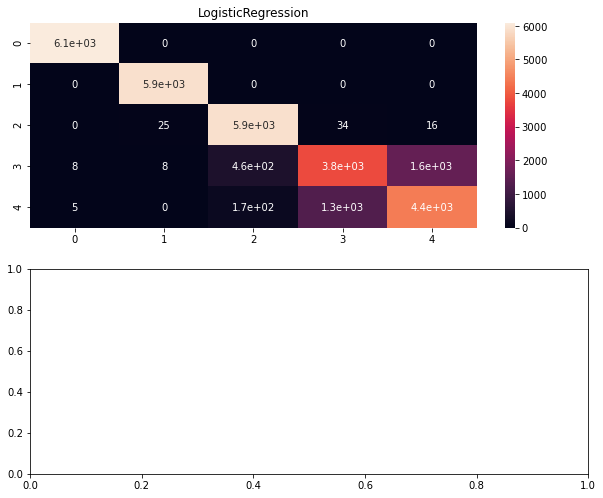

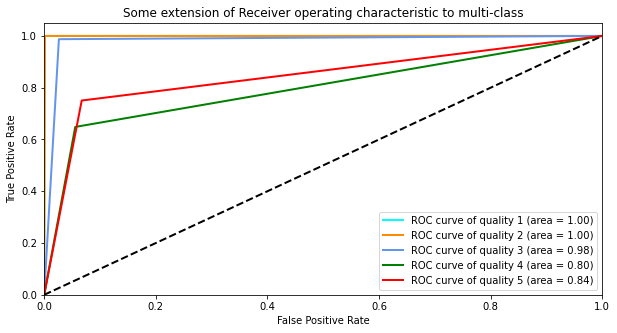




*********************** DecisionTreeClassifier ***********************


DecisionTreeClassifier()


Accuracy_score =  0.8523009741350352


roc_auc_score =  0.9069915451154198


classification_report
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      6099
           2       0.99      1.00      1.00      5925
           3       0.90      0.95      0.92      5991
           4       0.67      0.64      0.65      5875
           5       0.68      0.67      0.68      5880

    accuracy                           0.85     29770
   macro avg       0.85      0.85      0.85     29770
weighted avg       0.85      0.85      0.85     29770



[[6095    0    2    0    2]
 [   0 5921    1    3    0]
 [   1    1 5674  173  142]
 [  11   24  414 3761 1665]
 [  15   11  248 1684 3922]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)


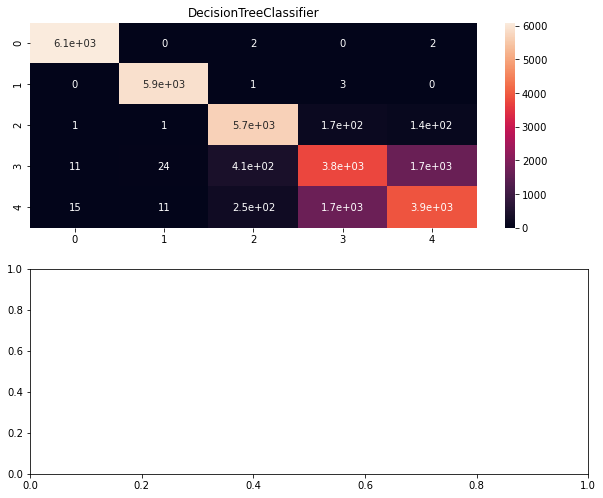

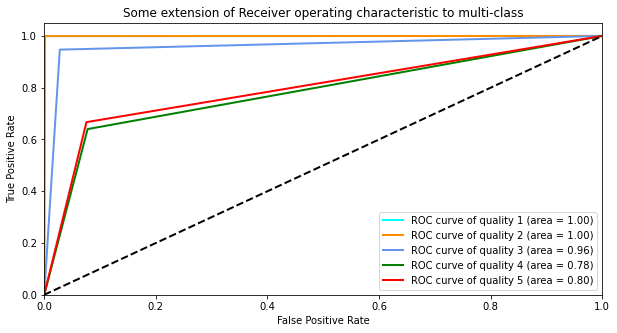




*********************** MultinomialNB ***********************


MultinomialNB()


Accuracy_score =  0.846657709103124


roc_auc_score =  0.9034100836426318


classification_report
               precision    recall  f1-score   support

           1       0.98      1.00      0.99      6099
           2       0.99      1.00      0.99      5925
           3       0.85      0.96      0.90      5991
           4       0.64      0.71      0.67      5875
           5       0.75      0.56      0.64      5880

    accuracy                           0.85     29770
   macro avg       0.84      0.84      0.84     29770
weighted avg       0.84      0.85      0.84     29770



[[6099    0    0    0    0]
 [   0 5925    0    0    0]
 [  27   31 5746  136   51]
 [  54   34  607 4146 1034]
 [  49   24  368 2150 3289]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)


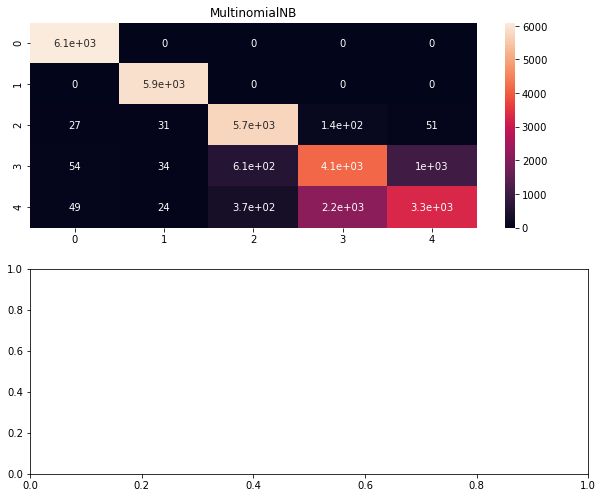

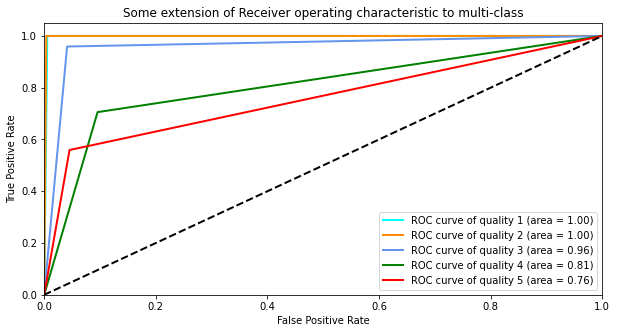




*********************** RandomForestClassifier ***********************


RandomForestClassifier()


Accuracy_score =  0.9133355727242191


roc_auc_score =  0.9453904438285424


classification_report
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      6099
           2       1.00      1.00      1.00      5925
           3       1.00      1.00      1.00      5991
           4       0.77      0.81      0.79      5875
           5       0.80      0.76      0.78      5880

    accuracy                           0.91     29770
   macro avg       0.91      0.91      0.91     29770
weighted avg       0.91      0.91      0.91     29770



[[6098    0    0    0    1]
 [   0 5924    0    0    1]
 [   0    0 5965   12   14]
 [   0    0   22 4757 1096]
 [   0    0    7 1427 4446]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)


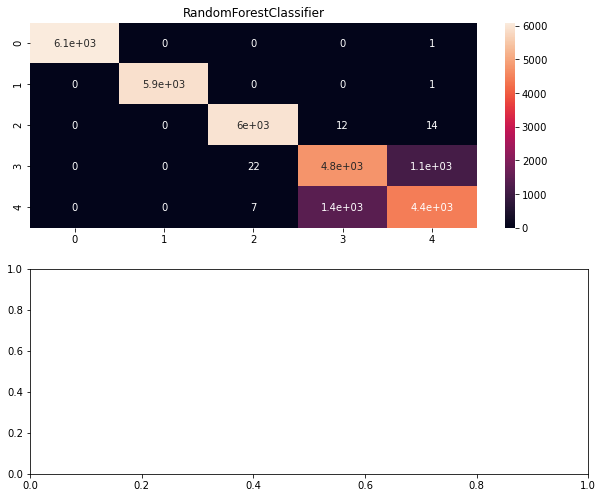

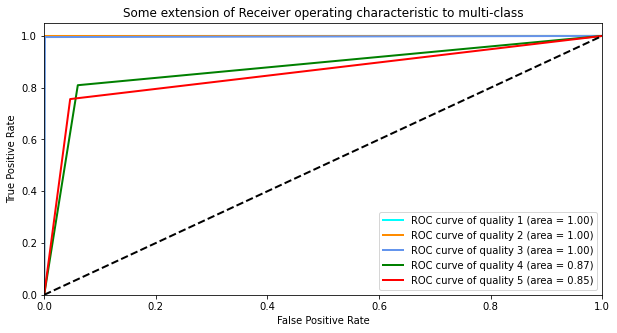




*********************** GradientBoostingClassifier ***********************


GradientBoostingClassifier()


Accuracy_score =  0.8153846153846154


roc_auc_score =  0.8839923689431527


classification_report
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      6099
           2       1.00      1.00      1.00      5925
           3       0.85      0.78      0.82      5991
           4       0.61      0.63      0.62      5875
           5       0.63      0.65      0.64      5880

    accuracy                           0.82     29770
   macro avg       0.82      0.81      0.82     29770
weighted avg       0.82      0.82      0.82     29770



[[6097    0    0    0    2]
 [   0 5923    0    0    2]
 [   1    0 4697  698  595]
 [  10    7  471 3729 1658]
 [  10    2  348 1692 3828]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)


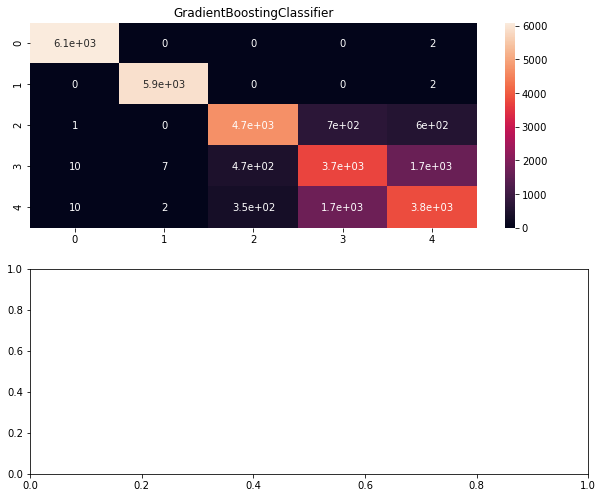

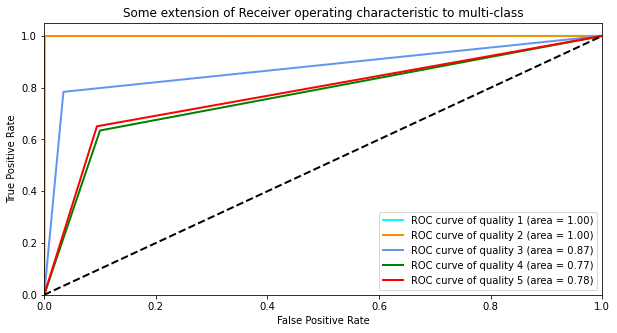

In [37]:

Model = []
score = []
cvs=[]
rocscore=[]

fpr = dict()
tpr = dict()
roc_auc = dict()
for name,model in models:
    print('***********************',name,'***********************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    AS=accuracy_score(y_test,pre)
    print('Accuracy_score = ',AS)
    score.append(AS*100)
    print('\n')
    #sc = cross_val_score(model, x, y, cv=10, scoring='accuracy').mean()
    #print('Cross_Val_Score = ',sc)
    #cvs.append(sc*100)
    #print('\n')
    #For ROC curves we have to binarize lables
    y_test_bin = label_binarize(y_test, classes=classes_q)
    y_pred_bin = label_binarize(pre, classes=classes_q)
    for i in range(len(classes_q)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes_q))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes_q)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes_q)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    #for average of roc_auc
    l=len(roc_auc)
    for i in range(l):
        sroc=sum(roc_auc.values())
    froc=sroc/l
    print ('roc_auc_score = ',froc)
    rocscore.append(froc*100)
    print('\n')
    print('classification_report\n',classification_report(y_test,pre))
    print('\n')
    cm=confusion_matrix(y_test,pre)
    print(cm)
    print('\n')
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    print(sns.heatmap(cm,annot=True))
    plt.subplot(912)
    plt.figure(figsize=(10,5))
    
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'magenta']
    for i, color in zip(range(len(classes_q)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                   label='ROC curve of quality {0} (area = {1:0.2f})'
                       ''.format(classes_q[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    print('\n\n')

In [38]:
result = pd.DataFrame({'Model': Model, 'Accuracy_score': score ,'Rou_auc_score':rocscore})
result

,Model,Accuracy_score,Rou_auc_score
0,KNeighborsClassifier,80.157877,87.491211
1,SVC,91.484716,94.636035
2,LogisticRegression,87.883776,92.364481
3,DecisionTreeClassifier,85.230097,90.699155
4,MultinomialNB,84.665771,90.341008
5,RandomForestClassifier,91.333557,94.539044
6,GradientBoostingClassifier,81.538462,88.399237


In [41]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

grid = RandomizedSearchCV(estimator = RFC, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
grid.fit(x,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [130, 180, 230]},
                   random_state=42, verbose=2)

In [42]:
print(grid)
#print(grid.best_score)
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [130, 180, 230]},
                   random_state=42, verbose=2)
RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=5, n_estimators=180)
{'n_estimators': 180, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
0.8340871300299302


In [43]:
rfc=RandomForestClassifier(max_depth = None, max_features='sqrt', min_samples_leaf=1,
                       min_samples_split=5, n_estimators=180)
rfc.fit(x_train,y_train)
pred=rfc.predict(x_test)

In [44]:
pred

array([5, 1, 5, ..., 4, 3, 4], dtype=int64)

In [45]:
y_test

86337    5
41125    1
89825    5
17604    4
34240    1
        ..
25627    4
88720    5
10477    5
19662    3
14839    5
Name: Rating, Length: 29770, dtype: int64

In [46]:
print( accuracy_score(y_test, pred) )

0.9153846153846154


In [48]:
joblib.dump(rfc,'review_rating.pkl')

['review_rating.pkl']

In [49]:
model=joblib.load('review_rating.pkl')

In [50]:
model.predict(x_test)

array([5, 1, 5, ..., 4, 3, 4], dtype=int64)